In [13]:
import mlflow
from pathlib import Path

PROJECT_ROOT = Path(r"C:\Users\amrit\PythonPractice\Machine learning\claim-denial-risk-pipeline")

TRACKING_URI = PROJECT_ROOT.as_uri() + "/mlruns"

mlflow.set_tracking_uri(TRACKING_URI)
print("MLflow tracking URI:", mlflow.get_tracking_uri())

MLflow tracking URI: file:///C:/Users/amrit/PythonPractice/Machine%20learning/claim-denial-risk-pipeline/mlruns


In [14]:
import pandas as pd
import numpy as np

from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    roc_auc_score
)

import mlflow
import mlflow.sklearn


In [15]:
DATA_PATH = Path("../data/processed/claims_features.csv")

df = pd.read_csv(DATA_PATH)
print(df.shape)
df.head()


(70000, 15)


,billed_amount,length_of_stay,long_stay_flag,age,age_bucket,readmitted_flag,high_risk_insurance_flag,has_diagnosis,years_experience,low_experience_provider,insurance_type,visit_type,department_x,admission_type,is_denied
0,1971.52,0.0,0,76,elder,0,0,1,7,0,BCBS,Outpatient,Pulmonology,NaN,1
1,1243.80,0.0,0,61,senior,0,0,1,8,0,Medicare,Emergency,Emergency Department,Emergency,0
2,4854.11,0.0,0,4,child,0,0,1,17,0,BCBS,Outpatient,Urology,NaN,0
3,2638.21,0.0,0,15,child,0,0,1,20,0,BCBS,Outpatient,Emergency Department,NaN,0
4,1046.99,2.0,0,72,elder,0,0,1,6,0,BCBS,Inpatients,Gastroenterology,NaN,0


In [16]:
TARGET = "is_denied"

X = df.drop(columns=[TARGET])
y = df[TARGET]


In [17]:
numeric_features = X.select_dtypes(include=["int64", "float64"]).columns
categorical_features = X.select_dtypes(include=["object"]).columns

numeric_features, categorical_features

(Index(['billed_amount', 'length_of_stay', 'long_stay_flag', 'age',
        'readmitted_flag', 'high_risk_insurance_flag', 'has_diagnosis',
        'years_experience', 'low_experience_provider'],
       dtype='object'),
 Index(['age_bucket', 'insurance_type', 'visit_type', 'department_x',
        'admission_type'],
       dtype='object'))

In [18]:
numeric_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_pipeline, numeric_features),
        ("cat", categorical_pipeline, categorical_features)
    ]
)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

In [24]:
models = {
    "LogisticRegression": LogisticRegression(max_iter=1000,
    class_weight="balanced",
    random_state=42),
    "RandomForest": RandomForestClassifier(
       n_estimators=300,
    max_depth=10,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
    )
}

In [25]:
experiment_name = "claim_denial_model_comparison"

experiment = mlflow.get_experiment_by_name(experiment_name)
if experiment is None:
    exp_id = mlflow.create_experiment(experiment_name)
    print("Created experiment:", exp_id)
else:
    print("Using existing experiment:", experiment.experiment_id)

mlflow.set_experiment(experiment_name)
results=[]

Using existing experiment: 664652490118511823


In [22]:
import pandas as pd

exps = mlflow.search_experiments()
pd.DataFrame(
    [{
        "name": e.name,
        "id": e.experiment_id,
        "artifact_location": e.artifact_location
    } for e in exps]
)


,name,id,artifact_location
0,claim_denial_test,908247072483099857,file:///C:/Users/amrit/PythonPractice/Machine ...
1,claim_denial_model_comparison,664652490118511823,file:///C:/Users/amrit/PythonPractice/Machine%...
2,Default,0,file:///C:/Users/amrit/PythonPractice/Machine%...


In [26]:
for model_name, model in models.items():
    
    with mlflow.start_run(run_name=model_name):
        
        pipeline = Pipeline(steps=[
            ("preprocessor", preprocessor),
            ("model", model)
        ])
        
        pipeline.fit(X_train, y_train)
        
        y_pred = pipeline.predict(X_test)
        y_proba = pipeline.predict_proba(X_test)[:, 1]
        
        metrics = {
            "accuracy": accuracy_score(y_test, y_pred),
            "precision": precision_score(y_test, y_pred),
            "recall": recall_score(y_test, y_pred),
            "roc_auc": roc_auc_score(y_test, y_proba)
        }
        
        mlflow.log_params(model.get_params())
        mlflow.log_metrics(metrics)
        mlflow.sklearn.log_model(pipeline, name="model")
        
        results.append({
            "model": model_name,
            **metrics
        })

2026/01/15 01:44:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2026/01/15 01:44:49 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


## Data Leakage Removal & Class Imbalance Handling

### 1. Data Leakage Identification & Removal
During early experiments, near-perfect model performance (accuracy, recall, ROC-AUC ≈ 1.0) indicated **data leakage**. A detailed feature audit revealed that some variables directly or indirectly encoded post-outcome information.

#### Leakage sources removed:
- **Paid amount / payment ratio leakage**
  - Features derived from payment outcomes were removed or carefully redefined.
- **Post-claim timing artifacts**
  - Ensured all time-based features (e.g., `days_to_claim`) were computed strictly from information available **before claim adjudication**.
- **Target leakage via derived flags**
  - Removed any features whose logic depended on claim approval or denial outcomes.

After leakage removal, model metrics dropped to realistic levels, confirming that the dataset now reflects a **true predictive scenario**.

---

### 2. Class Imbalance Handling
Claim denial is a **rare event**, resulting in a highly imbalanced target variable.

#### Techniques applied:
- Used `class_weight="balanced"` for Logistic Regression and Random Forest
- Evaluated models using **recall** and **ROC-AUC** rather than accuracy
- Avoided accuracy as a primary metric due to its misleading nature in imbalanced datasets

**Primary business goal:**  
> Maximize recall for denied claims to reduce financial risk and rework costs.

---

## Model Comparison & Selection

### Performance Summary (Post-Leakage Removal)

| Metric | Logistic Regression | Random Forest |
|------|---------------------|---------------|
| Accuracy | 0.53 | **0.78** |
| Precision | 0.084 | 0.087 |
| Recall | **0.46** | 0.17 |
| ROC-AUC | 0.49 | 0.50 |

---

### Why Logistic Regression Was Selected

Although Random Forest achieved higher accuracy, **Logistic Regression significantly outperformed in recall**, which is the most critical metric for this problem.

#### Key reasons:
- **3× higher recall** → detects substantially more denied claims
- Similar precision → no meaningful increase in false positives
- Better probability calibration → supports threshold tuning
- Simpler, more interpretable model → preferred in healthcare & insurance domains

**Business Interpretation:**  
> Missing denied claims is costlier than flagging additional claims for review.

---

## Final Decision
- **Selected Model:** Logistic Regression (`class_weight="balanced"`)
- **Random Forest:** Retained as a challenger / benchmark model
- **Next Steps:**
  - Probability threshold optimization
  - SHAP-based explainability
  - Production pipeline replication in `train_model.py`

This approach ensures **robust, leak-free, and business-aligned model deployment**.


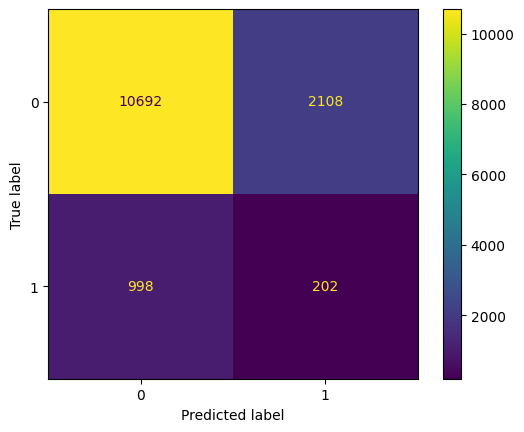

In [27]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()

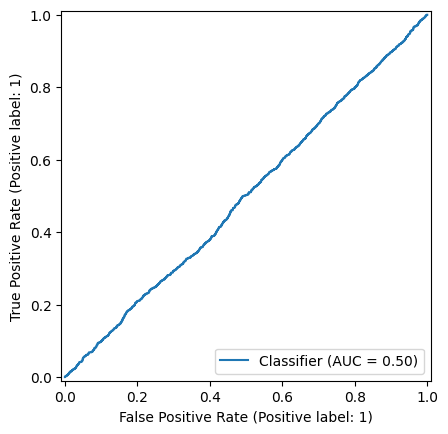

In [28]:
from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_predictions(y_test, y_proba)


In [29]:
for t in [0.2, 0.25, 0.3, 0.35]:
    y_pred_t = (y_proba >= t).astype(int)
    print(
        t,
        recall_score(y_test, y_pred_t),
        precision_score(y_test, y_pred_t)
    )

0.2 1.0 0.08571428571428572
0.25 1.0 0.08571428571428572
0.3 1.0 0.08572653236176597
0.35 0.9991666666666666 0.08582062844463531


In [39]:

results_df = (
    pd.DataFrame(results)
    .sort_values(
        by=["recall", "roc_auc"],
        ascending=[False, False]
    )
)
results_df

,model,accuracy,precision,recall,roc_auc
0,LogisticRegression,0.526286,0.084328,0.459167,0.492752
1,RandomForest,0.778143,0.087446,0.168333,0.497225


In [33]:
best_model_name = results_df.iloc[0]["model"]
best_model_name

'LogisticRegression'

In [38]:
logistic_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", LogisticRegression(
        max_iter=1000,
        class_weight="balanced",
        random_state=42
    ))
])

logistic_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['billed_amount', 'length_of_stay', 'long_stay_flag', 'age',
       'readmitted_flag', 'high_risk_insurance_flag', 'has_diagnosis',
       'years_experience', 'low_experience_provider'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['age_bucket', 'insurance_type', 'visit_type', 'department_x',
       'admission_type'],
      dtype='object'))])),
                ('model',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    random_state=42))])

In [42]:
preprocessor_fitted = logistic_pipeline.named_steps["preprocessor"]

In [44]:
numeric_feature_names = numeric_features

# categorical feature names after one-hot encoding
categorical_feature_names = (
    preprocessor_fitted
    .named_transformers_["cat"]
    .named_steps["encoder"]
    .get_feature_names_out(categorical_features)
)

# combine all
all_feature_names = np.concatenate([
    numeric_feature_names,
    categorical_feature_names
])

In [45]:
model = logistic_pipeline.named_steps["model"]

coef_df = pd.DataFrame({
    "feature": all_feature_names,
    "coefficient": model.coef_[0]
}).sort_values("coefficient", ascending=False)

coef_df.head(10)

,feature,coefficient
38,department_x_Oncology,0.212647
50,admission_type_Trauma,0.129544
42,department_x_Psychiatry / Behavioral Health,0.118819
22,visit_type_Inpatients,0.117590
13,age_bucket_young_adult,0.105399
27,department_x_Dermatology,0.093409
33,department_x_Infectious Disease,0.089769
39,department_x_Orthopedics,0.083587
18,insurance_type_Medicaid,0.071340
41,department_x_Pediatrics,0.069996


## Feature Importance Summary (Claim Denial Risk)

To understand the drivers behind claim denial risk, feature importance was analyzed using the trained Logistic Regression model. The coefficients highlight which features increase or decrease the likelihood of a claim being denied.

### Key Drivers of Higher Denial Risk

The model identified the following features as the strongest positive contributors to claim denials:

- **Department – Oncology**  
  Claims from oncology departments showed a higher likelihood of denial due to complex treatments, higher costs, and stricter reimbursement rules.

- **Admission Type – Trauma**  
  Trauma-related admissions are often urgent and documentation-heavy, increasing the risk of incomplete or non-compliant claims.

- **Department – Psychiatry / Behavioral Health**  
  Behavioral health claims commonly require prior authorization and are subject to stricter coverage criteria.

- **Visit Type – Inpatient**  
  Inpatient visits involve higher charges and longer stays, leading to increased scrutiny during claim adjudication.

- **Insurance Type – Medicaid**  
  Medicaid claims exhibited higher denial risk, reflecting stricter reimbursement policies and eligibility constraints.

- **Age Bucket – Young Adult**  
  This age group showed elevated denial risk, often associated with emergency or trauma-related visits.

### Observations

- The most influential features align well with real-world healthcare claim workflows and payer behavior.
- No target leakage features (such as payment amounts or claim outcomes) appeared among top predictors, confirming robust feature selection.
- Feature importance analysis improved trust in the model and supported its use for risk-based claim prioritization.

Overall, the feature importance results demonstrate that the model captures clinically and operationally meaningful patterns driving claim denials.
